## Digit Recognizer
Learn computer vision fundamentals with the famous MNIST dat

https://www.kaggle.com/c/digit-recognizer

### Competition Description
MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

In this competition, your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. We’ve curated a set of tutorial-style kernels which cover everything from regression to neural networks. We encourage you to experiment with different algorithms to learn first-hand what works well and how techniques compare.

### Practice Skills
Computer vision fundamentals including simple neural networks

Classification methods such as SVM and K-nearest neighbors

#### Acknowledgements 
More details about the dataset, including algorithms that have been tried on it and their levels of success, can be found at http://yann.lecun.com/exdb/mnist/index.html. The dataset is made available under a Creative Commons Attribution-Share Alike 3.0 license.

In [0]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline

In [0]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import losses,optimizers,metrics
from tensorflow.keras import layers

## Data Preparation

In [7]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
labeled_images = pd.read_csv('gdrive/My Drive/dataML/train.csv')
#labeled_images = pd.read_csv('train.csv')
images = labeled_images.iloc[:,1:]
labels = labeled_images.iloc[:,:1]
train_images, test_images,train_labels, test_labels = train_test_split(images, labels, test_size=0.01)

In [39]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(41580, 784)
(41580, 1)
(420, 784)
(420, 1)


## Keras

#### convert the data to the right type

In [0]:
x_train = train_images.values.reshape(train_images.shape[0],28,28,1)
x_test = test_images.values.reshape(test_images.shape[0],28,28,1)
y_train = train_labels.values
y_test = test_labels.values

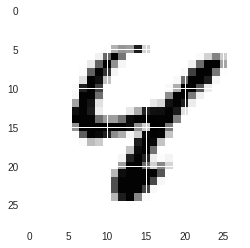

In [41]:
plt.imshow(x_train[12].squeeze())

#### convert the data to the right type

In [42]:
x_train = train_images
x_test = test_images
x_train /= 255
x_test /= 255
y_train = train_labels
y_test = test_labels
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (41580, 784)
41580 train samples
420 test samples


### convert class vectors to binary class matrices - this is for use in the
### categorical_crossentropy loss below

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

### Creating the Model


In [46]:
model = models.Sequential()

model.add(layers.Dense(units=200, activation='relu',input_shape=(784,)))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units=60, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units=30, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(units=10, activation='softmax'))

model.summary()          

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                6060      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
___________________________

In [0]:
adam = keras.optimizers.Adam(lr = 0.0001)

model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=adam, 
              metrics=['accuracy'])

In [0]:
H = model.fit(x_train, y_train,
          batch_size=100,
          epochs=300,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 41580 samples, validate on 420 samples
Epoch 1/300
41580/41580 [==============================] - 5s 118us/sample - loss: 0.7477 - acc: 0.7655 - val_loss: 0.3542 - val_acc: 0.9095
Epoch 2/300
14400/41580 [=========>....................] - ETA: 2s - loss: 0.6184 - acc: 0.8147

In [0]:
H.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

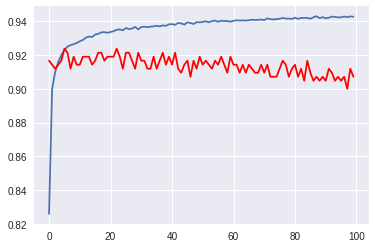

In [0]:
plt.plot(H.history['acc'])
plt.plot(H.history['val_acc'],'r')

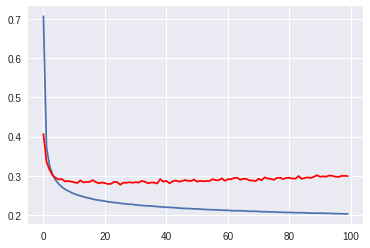

In [0]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'],'r')

### Predict

In [0]:
unlabeled_images_test = pd.read_csv('gdrive/My Drive/dataML/test.csv')
#unlabeled_images_test = pd.read_csv('test.csv')

In [0]:
X_unlabeled = unlabeled_images_test.values.reshape(unlabeled_images_test.shape[0],28,28,1)/255

In [0]:
y_pred = model.predict(X_unlabeled)

In [0]:
y_label = np.argmax(y_pred, axis=1)

### Save csv

In [0]:
imageId = np.arange(1,y_label.shape[0]+1).tolist()
prediction_pd = pd.DataFrame({'ImageId':imageId, 'Label':y_label})
prediction_pd.to_csv('gdrive/My Drive/dataML/out_cnn05.csv',sep = ',', index = False)

# Tensorflow

### Helper functions for batch learning

In [0]:
def one_hot_encode(vec, vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [0]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        # Vertically stacks the training images
        self.training_images = train_images.as_matrix()
        train_len = self.training_images.shape[0]
        
        # Reshapes and normalizes training images
        self.training_images = self.training_images.reshape(train_len,28,28,1)/255
        # One hot Encodes the training labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.training_labels = one_hot_encode(train_labels.as_matrix().reshape(-1), 10)
        
        print("Setting Up Test Images and Labels")
        
        # Vertically stacks the test images
        self.test_images = test_images.as_matrix()
        test_len = self.test_images.shape[0]
        
        # Reshapes and normalizes test images
        self.test_images = self.test_images.reshape(test_len,28,28,1)/255
        # One hot Encodes the test labels (e.g. [0,0,0,1,0,0,0,0,0,0])
        self.test_labels = one_hot_encode(test_labels.as_matrix().reshape(-1), 10)

        
    def next_batch(self, batch_size):
        # Note that the 100 dimension in the reshape call is set by an assumed batch size of 100
        x = self.training_images[self.i:self.i+batch_size]
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [13]:
# Before Your tf.Session run these two lines
ch = CifarHelper()
ch.set_up_images()

# During your session to grab the next batch use this line
# (Just like we did for mnist.train.next_batch)
# batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model



** Create 2 placeholders, x and y_true. Their shapes should be: **

* X shape = [None,28,28,1]
* Y_true shape = [None,10]

** Create three more placeholders 
* lr: learning rate
* step：for learning rate decay
* drop_rate

In [0]:
X = tf.placeholder(tf.float32, shape=[None,28,28,1])
Y_true = tf.placeholder(tf.float32, shape=[None,10])

lr = tf.placeholder(tf.float32)
step = tf.placeholder(tf.int32)
drop_rate = tf.placeholder(tf.float32)

### Initialize Weights and bias
Five layers with 200, 100, 60, 30 and 10 neurons

In [0]:
L = 200
M = 100
N = 60
O = 30

In [0]:
W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
B1 = tf.Variable(tf.ones([L])/10)

W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
B2 = tf.Variable(tf.ones([M])/10)

W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
B3 = tf.Variable(tf.ones([N])/10)

W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
B4 = tf.Variable(tf.ones([O])/10)

W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))

B5 = tf.Variable(tf.zeros([10]))

### layers

In [0]:
XX = tf.reshape(X,[-1,784])

In [0]:
Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
Y1d = tf.nn.dropout(Y1,rate = drop_rate)

Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
Y2d = tf.nn.dropout(Y2,rate = drop_rate)

Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
Y3d = tf.nn.dropout(Y3,rate = drop_rate)

Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
Y4d = tf.nn.dropout(Y4,rate = drop_rate)

Ylogits = tf.matmul(Y4, W5) + B5
Y = tf.nn.softmax(Ylogits)

### Loss Function

In [0]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_true,logits=Ylogits))
cross_entropy = tf.losses.softmax_cross_entropy(onehot_labels = Y_true, logits = Ylogits)
#cross_entropy = -tf.reduce_mean(y_true * tf.log(Ylogits)) * 1000.0 

### Optimizer

In [0]:
lr = 0.0001 + tf.train.exponential_decay(learning_rate = 0.003, 
                                         global_step = step,
                                         decay_steps = 2000,
                                         decay_rate = 1/math.e
                                        )

#optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.005)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train = optimizer.minimize(cross_entropy)

### Intialize Variables

In [0]:
init = tf.global_variables_initializer()

### Saving the Model

In [0]:
saver = tf.train.Saver()

## Graph Session

** Perform the training and test print outs in a Tf session and run your model! **

In [37]:
history = {'acc_train':list(),'acc_val':list(),
           'loss_train':list(),'loss_val':list(),
          'learning_rate':list()}
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(20000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={X: batch[0], Y_true: batch[1], step: i, drop_rate: 0.25})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            # Test the Train Model
            feed_dict_train = {X: batch[0], Y_true: batch[1], drop_rate: 0.25}
            feed_dict_val = {X:ch.test_images, Y_true:ch.test_labels, drop_rate: 0}

            matches = tf.equal(tf.argmax(Y,1),tf.argmax(Y_true,1))
            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            history['acc_train'].append(sess.run(acc, feed_dict = feed_dict_train))
            history['acc_val'].append(sess.run(acc, feed_dict = feed_dict_val))

            history['loss_train'].append(sess.run(cross_entropy, feed_dict = feed_dict_train))
            history['loss_val'].append(sess.run(cross_entropy, feed_dict = feed_dict_val))
            
            history['learning_rate'].append(sess.run(lr, feed_dict = {step: i}))
            print("Iteration {}:\tlearning_rate={:.6f},\tloss_train={:.6f},\tloss_val={:.6f},\tacc_train={:.6f},\tacc_val={:.6f}"
                  .format(i,history['learning_rate'][-1],
                          history['loss_train'][-1],
                          history['loss_val'][-1],
                          history['acc_train'][-1],
                          history['acc_val'][-1]))
            
            print('\n')
        
    saver.save(sess,'models_saving/my_model.ckpt')

Iteration 0:	learning_rate=0.003100,	loss_train=2.182136,	loss_val=2.249882,	acc_train=0.340000,	acc_val=0.240476


Iteration 100:	learning_rate=0.002954,	loss_train=0.467531,	loss_val=0.311416,	acc_train=0.850000,	acc_val=0.909524


Iteration 200:	learning_rate=0.002815,	loss_train=0.137905,	loss_val=0.242698,	acc_train=0.960000,	acc_val=0.928571


Iteration 300:	learning_rate=0.002682,	loss_train=0.210080,	loss_val=0.177731,	acc_train=0.910000,	acc_val=0.954762


Iteration 400:	learning_rate=0.002556,	loss_train=0.124743,	loss_val=0.154332,	acc_train=0.960000,	acc_val=0.947619


Iteration 500:	learning_rate=0.002436,	loss_train=0.073579,	loss_val=0.153308,	acc_train=0.980000,	acc_val=0.947619


Iteration 600:	learning_rate=0.002322,	loss_train=0.142366,	loss_val=0.138387,	acc_train=0.950000,	acc_val=0.950000


Iteration 700:	learning_rate=0.002214,	loss_train=0.078855,	loss_val=0.133273,	acc_train=0.980000,	acc_val=0.961905


Iteration 800:	learning_rate=0.002111,	loss_train=0.173613

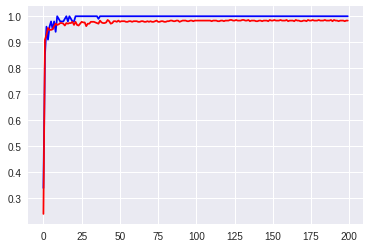

In [38]:
plt.plot(history['acc_train'],'b')
plt.plot(history['acc_val'],'r')

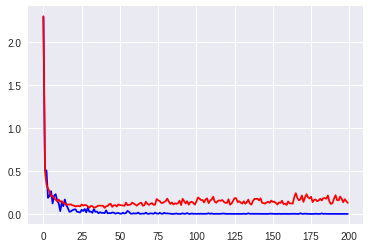

In [0]:
plt.plot(history['loss_train'],'b')
plt.plot(history['loss_val'],'r')

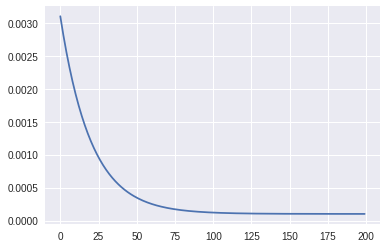

In [27]:
plt.plot(history['learning_rate'])

### Loading a Model

In [0]:
with tf.Session() as sess:
    
    # Restore the model
    saver.restore(sess, 'models_saving/my_model.ckpt')
    

    # Fetch Back Results
    label = sess.run(y_pred, feed_dict={x:X_unlabeled,hold_prob:1.0})

INFO:tensorflow:Restoring parameters from models_saving/my_model.ckpt


In [0]:
label.shape

(28000, 10)

In [0]:
label = np.argmax(label, axis=1 )

In [0]:
label.shape

(28000,)

### Predict

In [0]:
unlabeled_images_test = pd.read_csv('gdrive/My Drive/dataML/test.csv')
#unlabeled_images_test = pd.read_csv('test.csv')

In [0]:
X_unlabeled = unlabeled_images_test.values.reshape(unlabeled_images_test.shape[0],28,28,1)/255

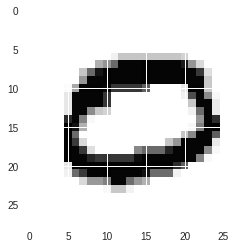

In [0]:
plt.imshow(X_unlabeled[1].reshape(28,28))

In [0]:
X_unlabeled.shape

(28000, 28, 28, 1)

## Predict the unlabeled test sets using the model

In [0]:
imageId = np.arange(1,label.shape[0]+1).tolist()

In [0]:
prediction_pd = pd.DataFrame({'ImageId':imageId, 'Label':label})

In [0]:
prediction_pd.to_csv('out_cnn4.csv',sep = ',', index = False)